## Preparation

### Download the optimization support library package

In [1]:
!pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 390.6/390.6 kB 22.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 28.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 9.9 MB/s eta 0:00:00


### Connect to Google Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


## Import Libraries

In [3]:
# Library to support working with data
import numpy as np
import pandas as pd

# Graphing support library
import matplotlib.pyplot as plt

# Data Normalization Support Library
from sklearn.preprocessing import MinMaxScaler

# Library to support building Temporal Convolutional Attention Networks models
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, Flatten, Conv1D, MaxPooling1D, GlobalMaxPooling1D, Dropout, SpatialDropout1D
from tensorflow.keras.layers import Layer, RepeatVector, concatenate, Reshape, Input, Concatenate, Permute, Multiply, Add, Activation

# Performance metrics calculation support library
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_squared_log_error

# Parameter optimization support library
import optuna

# Support library to ignore warnings
import warnings
warnings.filterwarnings("ignore")

# Support library to load models and data
from keras.utils import custom_object_scope
from tensorflow.keras.models import load_model

## Data preprocessing

### Read data

In [4]:
# Load data
df = pd.read_csv('NTR.csv')
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-01-02,46.209999,46.990002,45.855000,46.259998,40.076595,1289100
1,2019-01-03,46.000000,46.099998,44.882999,45.049999,39.028339,1158800
2,2019-01-04,45.950001,47.180000,45.880001,47.130001,40.830315,1538500
3,2019-01-07,47.310001,48.110001,46.840000,47.740002,41.358772,954700
4,2019-01-08,48.709999,49.480000,48.520000,49.209999,42.632286,1921800
...,...,...,...,...,...,...,...
1114,2023-06-06,53.000000,57.294998,52.820000,57.220001,57.220001,6397900
1115,2023-06-07,57.610001,59.750000,57.520000,59.340000,59.340000,2925500
1116,2023-06-08,59.400002,60.080002,57.910000,58.939999,58.939999,2828400
1117,2023-06-09,58.959999,59.349998,58.290001,58.790001,58.790001,1686600


### Reset index

In [5]:
# Convert the 'Date' column to datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Set the 'Date' column as the index value
df.set_index('Date', inplace=True)

In [6]:
# Select column 'Close'
df_Close = df[['Close']]
df_Close = df_Close.reset_index(drop=True)

### Data normalization

In [7]:
# Min-max normalization
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(np.array(df_Close))

### Data splitting

In [8]:
# Split the data into train, validation, and test dataset in a ratio of 6:2:2
train_size = int(len(data_scaled) * 0.6)
val_size = int(len(data_scaled) * 0.2)
test_size = len(data_scaled) - train_size - val_size

train_data = data_scaled[: train_size]
val_data = data_scaled[train_size : train_size + val_size]
test_data = data_scaled[train_size + val_size :]

## Model training and testing

In [9]:
# Generating data using the window sliding method
def create_dataset(data, window_size):
    windows, targets = [], []
    for i in range(len(data) - window_size - 1):
        windows.append(data[i : (i + window_size), 0])
        targets.append(data[i + window_size, 0])
    return np.array(windows), np.array(targets)

### Building TCANs model

In [10]:
# Constructing sparse attention layer
class AttentionLayer(Layer):
    def __init__(self, attention_dim):
        super(AttentionLayer, self).__init__()
        self.attention_dim = attention_dim

    def build(self, input_shape):
        self.W1 = Dense(units=self.attention_dim, activation='tanh')
        self.W2 = Dense(units=1, activation='linear')
        super(AttentionLayer, self).build(input_shape)

    def call(self, x):
        score = self.W2(self.W1(x))
        score = Flatten()(score)
        score = Activation('softmax')(score)
        score = RepeatVector(x.shape[-1])(score)
        score = Permute([2, 1])(score)
        return Multiply()([x, score])

    def compute_output_shape(self, input_shape):
        return input_shape

In [11]:
# Build TCAN model
def build_tcan(window_size, input_dim=1, tcn_filters=64, tcn_kernel_size=2, dropout_rate=0.2, attention_dim=16):
    inputs = Input(shape=(window_size, input_dim))
    x = inputs
    x = Conv1D(filters=tcn_filters, kernel_size=tcn_kernel_size, padding='same', activation='relu')(x)
    x = SpatialDropout1D(rate=dropout_rate)(x)
    x = Conv1D(filters=tcn_filters, kernel_size=tcn_kernel_size, padding='same', activation='relu')(x)
    x = SpatialDropout1D(rate=dropout_rate)(x)

    # Additive Attention
    att = AttentionLayer(attention_dim)(x)
    max_pool_att = GlobalMaxPooling1D()(att)
    max_pool_x = GlobalMaxPooling1D()(x)
    x = concatenate([max_pool_att, max_pool_x])

    outputs = Dense(1)(x)

    model = Model(inputs=inputs, outputs=outputs)
    optimizer = Adam(learning_rate=0.001)
    model.compile(loss='mean_absolute_error', optimizer=optimizer)

    return model

### Learning process with combined parameter optimization

In [12]:
# Initialization of optimization parameters
best_mse = float('inf')
best_model = None
best_window_size = None
best_train_windows = None
best_train_targets = None
best_test_windows = None
best_test_targets = None
best_val_windows = None
best_val_targets = None
best_y_pred = None
best_mape = np.inf
best_rmse = np.inf
best_msle = np.inf

In [13]:
# Define the objective function for Optuna optimization
def objective(trial):
  global best_mse, best_model, best_window_size, best_train_windows
  global best_train_targets, best_test_windows, best_test_targets, best_val_windows
  global best_val_targets, best_y_pred, best_mape, best_rmse, best_msle

  # Define the search space for hyperparameters
  window_size = trial.suggest_int("window_size", 10, 100)
  tcn_filters = trial.suggest_int("tcn_filters", 32, 128)
  tcn_kernel_size = trial.suggest_int("tcn_kernel_size", 2, 5)
  dropout_rate = trial.suggest_float("dropout_rate", 0.1, 0.5)
  attention_dim = trial.suggest_int("attention_dim", 8, 32)

  # Build the TCAN model with the suggested hyperparameters
  model = build_tcan(window_size,
                     tcn_filters = tcn_filters,
                     tcn_kernel_size = tcn_kernel_size,
                     dropout_rate = dropout_rate,
                     attention_dim = attention_dim)

  train_windows, train_targets = create_dataset(train_data, window_size)
  test_windows, test_targets = create_dataset(test_data, window_size)
  val_windows, val_targets = create_dataset(val_data, window_size)

  # Train the model
  early_stop = EarlyStopping(monitor='val_loss', patience=5)
  model.fit(train_windows, train_targets,
            epochs=50, batch_size=32,
            validation_data=(val_windows, val_targets),
            shuffle=False, callbacks=[early_stop], verbose=0)

  # Testing the model on Test dataset
  y_pred = model.predict(test_windows)

  # Evaluate on MAPE, RMSE, MSLE
  temp_test_targets = test_targets
  temp_test_targets = scaler.inverse_transform(temp_test_targets.reshape(-1, 1))
  y_pred = scaler.inverse_transform(y_pred)

  mse = mean_squared_error(temp_test_targets, y_pred)
  rmse = np.sqrt(mse)
  mape = mean_absolute_percentage_error(temp_test_targets, y_pred)
  msle = mean_squared_log_error(temp_test_targets, y_pred)

  # Save the best model and related information
  if mse < best_mse or best_mse is None:
    best_model = model
    best_window_size = window_size
    best_y_pred = y_pred
    best_train_windows = train_windows
    best_train_targets = train_targets
    best_test_windows = test_windows
    best_test_targets = test_targets
    best_val_windows = val_windows
    best_val_targets = val_targets
    best_rmse = rmse
    best_mape = mape
    best_msle = msle
    best_mse = mse

  return mse

In [14]:
# Define the search space for the hyperparameters
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100)

[I 2023-06-14 07:32:45,592] A new study created in memory with name: no-name-ab4ab243-1134-400a-ac35-846e1e8052d5


7/7 [==============================] - 0s 5ms/step


[I 2023-06-14 07:33:13,029] Trial 0 finished with value: 15.828001743040309 and parameters: {'window_size': 28, 'tcn_filters': 122, 'tcn_kernel_size': 4, 'dropout_rate': 0.1566513795331752, 'attention_dim': 31}. Best is trial 0 with value: 15.828001743040309.


5/5 [==============================] - 0s 6ms/step


[I 2023-06-14 07:33:35,374] Trial 1 finished with value: 4.71609355874296 and parameters: {'window_size': 90, 'tcn_filters': 66, 'tcn_kernel_size': 3, 'dropout_rate': 0.1669681792582848, 'attention_dim': 15}. Best is trial 1 with value: 4.71609355874296.


5/5 [==============================] - 0s 5ms/step


[I 2023-06-14 07:33:43,792] Trial 2 finished with value: 6.595896388248179 and parameters: {'window_size': 71, 'tcn_filters': 37, 'tcn_kernel_size': 5, 'dropout_rate': 0.18635577875407217, 'attention_dim': 13}. Best is trial 1 with value: 4.71609355874296.


6/6 [==============================] - 0s 6ms/step


[I 2023-06-14 07:34:01,012] Trial 3 finished with value: 4.406950380609072 and parameters: {'window_size': 49, 'tcn_filters': 72, 'tcn_kernel_size': 2, 'dropout_rate': 0.20283777988342908, 'attention_dim': 12}. Best is trial 3 with value: 4.406950380609072.


6/6 [==============================] - 0s 4ms/step


[I 2023-06-14 07:34:10,553] Trial 4 finished with value: 5.524948343810288 and parameters: {'window_size': 33, 'tcn_filters': 55, 'tcn_kernel_size': 2, 'dropout_rate': 0.22902609012857522, 'attention_dim': 16}. Best is trial 3 with value: 4.406950380609072.


6/6 [==============================] - 1s 5ms/step


[I 2023-06-14 07:34:33,382] Trial 5 finished with value: 8.392725849628993 and parameters: {'window_size': 45, 'tcn_filters': 70, 'tcn_kernel_size': 4, 'dropout_rate': 0.22306655915449422, 'attention_dim': 26}. Best is trial 3 with value: 4.406950380609072.


6/6 [==============================] - 0s 4ms/step


[I 2023-06-14 07:34:45,515] Trial 6 finished with value: 4.603842921694632 and parameters: {'window_size': 47, 'tcn_filters': 49, 'tcn_kernel_size': 5, 'dropout_rate': 0.20859388373176635, 'attention_dim': 18}. Best is trial 3 with value: 4.406950380609072.


7/7 [==============================] - 0s 5ms/step


[I 2023-06-14 07:34:54,652] Trial 7 finished with value: 7.457347139691114 and parameters: {'window_size': 24, 'tcn_filters': 96, 'tcn_kernel_size': 5, 'dropout_rate': 0.28388065762723436, 'attention_dim': 10}. Best is trial 3 with value: 4.406950380609072.


6/6 [==============================] - 0s 4ms/step


[I 2023-06-14 07:35:05,062] Trial 8 finished with value: 10.970744236350075 and parameters: {'window_size': 56, 'tcn_filters': 45, 'tcn_kernel_size': 5, 'dropout_rate': 0.4175076534995221, 'attention_dim': 24}. Best is trial 3 with value: 4.406950380609072.


6/6 [==============================] - 0s 6ms/step


[I 2023-06-14 07:35:17,102] Trial 9 finished with value: 5.142325969887892 and parameters: {'window_size': 44, 'tcn_filters': 102, 'tcn_kernel_size': 2, 'dropout_rate': 0.44431375743955326, 'attention_dim': 30}. Best is trial 3 with value: 4.406950380609072.


7/7 [==============================] - 0s 3ms/step


[I 2023-06-14 07:35:22,193] Trial 10 finished with value: 8.947060283336542 and parameters: {'window_size': 11, 'tcn_filters': 88, 'tcn_kernel_size': 3, 'dropout_rate': 0.10936083679608366, 'attention_dim': 8}. Best is trial 3 with value: 4.406950380609072.


5/5 [==============================] - 0s 6ms/step


[I 2023-06-14 07:35:34,729] Trial 11 finished with value: 20.233430603841022 and parameters: {'window_size': 66, 'tcn_filters': 55, 'tcn_kernel_size': 3, 'dropout_rate': 0.30164982743590685, 'attention_dim': 19}. Best is trial 3 with value: 4.406950380609072.


5/5 [==============================] - 0s 7ms/step


[I 2023-06-14 07:35:51,094] Trial 12 finished with value: 4.806499213779686 and parameters: {'window_size': 73, 'tcn_filters': 77, 'tcn_kernel_size': 4, 'dropout_rate': 0.10448142143693252, 'attention_dim': 21}. Best is trial 3 with value: 4.406950380609072.


6/6 [==============================] - 0s 3ms/step


[I 2023-06-14 07:36:04,700] Trial 13 finished with value: 9.58869372664308 and parameters: {'window_size': 52, 'tcn_filters': 32, 'tcn_kernel_size': 2, 'dropout_rate': 0.2844581132187352, 'attention_dim': 12}. Best is trial 3 with value: 4.406950380609072.


6/6 [==============================] - 0s 5ms/step


[I 2023-06-14 07:36:27,212] Trial 14 finished with value: 6.955886310382549 and parameters: {'window_size': 59, 'tcn_filters': 58, 'tcn_kernel_size': 3, 'dropout_rate': 0.2385703381463817, 'attention_dim': 18}. Best is trial 3 with value: 4.406950380609072.


5/5 [==============================] - 0s 7ms/step


[I 2023-06-14 07:36:41,597] Trial 15 finished with value: 19.989920474612564 and parameters: {'window_size': 89, 'tcn_filters': 82, 'tcn_kernel_size': 4, 'dropout_rate': 0.38028792617697804, 'attention_dim': 14}. Best is trial 3 with value: 4.406950380609072.


6/6 [==============================] - 0s 5ms/step


[I 2023-06-14 07:36:52,338] Trial 16 finished with value: 7.556114087772147 and parameters: {'window_size': 39, 'tcn_filters': 110, 'tcn_kernel_size': 2, 'dropout_rate': 0.48957670968243117, 'attention_dim': 23}. Best is trial 3 with value: 4.406950380609072.


5/5 [==============================] - 0s 8ms/step


[I 2023-06-14 07:37:01,702] Trial 17 finished with value: 3.175098201523321 and parameters: {'window_size': 79, 'tcn_filters': 67, 'tcn_kernel_size': 5, 'dropout_rate': 0.34507256790491186, 'attention_dim': 17}. Best is trial 17 with value: 3.175098201523321.


5/5 [==============================] - 0s 6ms/step


[I 2023-06-14 07:37:14,344] Trial 18 finished with value: 3.2270546231095625 and parameters: {'window_size': 78, 'tcn_filters': 70, 'tcn_kernel_size': 3, 'dropout_rate': 0.32080929722275897, 'attention_dim': 10}. Best is trial 17 with value: 3.175098201523321.


5/5 [==============================] - 0s 8ms/step


[I 2023-06-14 07:37:27,316] Trial 19 finished with value: 9.62012840476599 and parameters: {'window_size': 82, 'tcn_filters': 90, 'tcn_kernel_size': 4, 'dropout_rate': 0.3394071814882494, 'attention_dim': 8}. Best is trial 17 with value: 3.175098201523321.


4/4 [==============================] - 0s 7ms/step


[I 2023-06-14 07:37:38,934] Trial 20 finished with value: 6.777692802290509 and parameters: {'window_size': 98, 'tcn_filters': 65, 'tcn_kernel_size': 3, 'dropout_rate': 0.3448429344535919, 'attention_dim': 27}. Best is trial 17 with value: 3.175098201523321.


5/5 [==============================] - 0s 5ms/step


[I 2023-06-14 07:37:53,655] Trial 21 finished with value: 2.7396403956643933 and parameters: {'window_size': 77, 'tcn_filters': 76, 'tcn_kernel_size': 2, 'dropout_rate': 0.2673165719659687, 'attention_dim': 11}. Best is trial 21 with value: 2.7396403956643933.


5/5 [==============================] - 0s 8ms/step


[I 2023-06-14 07:38:16,178] Trial 22 finished with value: 3.8639438198849256 and parameters: {'window_size': 82, 'tcn_filters': 80, 'tcn_kernel_size': 3, 'dropout_rate': 0.3209502663748211, 'attention_dim': 10}. Best is trial 21 with value: 2.7396403956643933.


5/5 [==============================] - 0s 9ms/step


[I 2023-06-14 07:38:28,883] Trial 23 finished with value: 8.332452919896136 and parameters: {'window_size': 81, 'tcn_filters': 63, 'tcn_kernel_size': 2, 'dropout_rate': 0.2721225751854002, 'attention_dim': 16}. Best is trial 21 with value: 2.7396403956643933.


5/5 [==============================] - 0s 5ms/step


[I 2023-06-14 07:38:38,328] Trial 24 finished with value: 7.00538273070898 and parameters: {'window_size': 65, 'tcn_filters': 72, 'tcn_kernel_size': 3, 'dropout_rate': 0.3649905545060634, 'attention_dim': 10}. Best is trial 21 with value: 2.7396403956643933.


4/4 [==============================] - 0s 9ms/step


[I 2023-06-14 07:39:05,004] Trial 25 finished with value: 26.41770205054663 and parameters: {'window_size': 98, 'tcn_filters': 88, 'tcn_kernel_size': 4, 'dropout_rate': 0.2607407234649418, 'attention_dim': 12}. Best is trial 21 with value: 2.7396403956643933.


5/5 [==============================] - 0s 7ms/step


[I 2023-06-14 07:39:27,381] Trial 26 finished with value: 5.890319942268404 and parameters: {'window_size': 75, 'tcn_filters': 78, 'tcn_kernel_size': 2, 'dropout_rate': 0.3083840454439282, 'attention_dim': 21}. Best is trial 21 with value: 2.7396403956643933.


5/5 [==============================] - 1s 11ms/step


[I 2023-06-14 07:39:40,704] Trial 27 finished with value: 9.391789648294006 and parameters: {'window_size': 91, 'tcn_filters': 48, 'tcn_kernel_size': 5, 'dropout_rate': 0.32635923010628937, 'attention_dim': 17}. Best is trial 21 with value: 2.7396403956643933.


5/5 [==============================] - 0s 9ms/step


[I 2023-06-14 07:39:54,994] Trial 28 finished with value: 4.5585042923388075 and parameters: {'window_size': 65, 'tcn_filters': 100, 'tcn_kernel_size': 3, 'dropout_rate': 0.25467575481957044, 'attention_dim': 14}. Best is trial 21 with value: 2.7396403956643933.


5/5 [==============================] - 0s 16ms/step


[I 2023-06-14 07:40:28,456] Trial 29 finished with value: 3.7260815607038773 and parameters: {'window_size': 79, 'tcn_filters': 119, 'tcn_kernel_size': 4, 'dropout_rate': 0.3015155618052551, 'attention_dim': 10}. Best is trial 21 with value: 2.7396403956643933.


6/6 [==============================] - 0s 7ms/step


[I 2023-06-14 07:40:41,651] Trial 30 finished with value: 8.358779969226688 and parameters: {'window_size': 60, 'tcn_filters': 84, 'tcn_kernel_size': 2, 'dropout_rate': 0.3684593663455308, 'attention_dim': 8}. Best is trial 21 with value: 2.7396403956643933.


5/5 [==============================] - 0s 11ms/step


[I 2023-06-14 07:41:00,172] Trial 31 finished with value: 10.375192537452257 and parameters: {'window_size': 80, 'tcn_filters': 127, 'tcn_kernel_size': 4, 'dropout_rate': 0.2946156851820498, 'attention_dim': 10}. Best is trial 21 with value: 2.7396403956643933.


5/5 [==============================] - 0s 13ms/step


[I 2023-06-14 07:41:22,727] Trial 32 finished with value: 49.30033902819858 and parameters: {'window_size': 88, 'tcn_filters': 121, 'tcn_kernel_size': 5, 'dropout_rate': 0.31734501150921385, 'attention_dim': 11}. Best is trial 21 with value: 2.7396403956643933.


5/5 [==============================] - 0s 14ms/step


[I 2023-06-14 07:42:05,935] Trial 33 finished with value: 4.821281404819354 and parameters: {'window_size': 71, 'tcn_filters': 113, 'tcn_kernel_size': 4, 'dropout_rate': 0.25686104782382024, 'attention_dim': 14}. Best is trial 21 with value: 2.7396403956643933.


5/5 [==============================] - 0s 7ms/step


[I 2023-06-14 07:42:18,853] Trial 34 finished with value: 5.164916429645214 and parameters: {'window_size': 92, 'tcn_filters': 60, 'tcn_kernel_size': 5, 'dropout_rate': 0.2886562686146603, 'attention_dim': 13}. Best is trial 21 with value: 2.7396403956643933.


5/5 [==============================] - 0s 7ms/step


[I 2023-06-14 07:42:29,941] Trial 35 finished with value: 3.0904701172372326 and parameters: {'window_size': 77, 'tcn_filters': 74, 'tcn_kernel_size': 4, 'dropout_rate': 0.3482889598037455, 'attention_dim': 9}. Best is trial 21 with value: 2.7396403956643933.


5/5 [==============================] - 0s 7ms/step


[I 2023-06-14 07:42:52,315] Trial 36 finished with value: 4.857519166771246 and parameters: {'window_size': 85, 'tcn_filters': 70, 'tcn_kernel_size': 3, 'dropout_rate': 0.3506682648422895, 'attention_dim': 15}. Best is trial 21 with value: 2.7396403956643933.


5/5 [==============================] - 0s 11ms/step


[I 2023-06-14 07:43:05,978] Trial 37 finished with value: 5.278596048206872 and parameters: {'window_size': 76, 'tcn_filters': 75, 'tcn_kernel_size': 5, 'dropout_rate': 0.38742123987705185, 'attention_dim': 9}. Best is trial 21 with value: 2.7396403956643933.


5/5 [==============================] - 0s 11ms/step


[I 2023-06-14 07:43:19,009] Trial 38 finished with value: 6.952453129459063 and parameters: {'window_size': 70, 'tcn_filters': 68, 'tcn_kernel_size': 4, 'dropout_rate': 0.3352284530098164, 'attention_dim': 12}. Best is trial 21 with value: 2.7396403956643933.


5/5 [==============================] - 0s 6ms/step


[I 2023-06-14 07:43:26,311] Trial 39 finished with value: 20.20997947382626 and parameters: {'window_size': 94, 'tcn_filters': 41, 'tcn_kernel_size': 5, 'dropout_rate': 0.40075225946246723, 'attention_dim': 32}. Best is trial 21 with value: 2.7396403956643933.


5/5 [==============================] - 0s 5ms/step


[I 2023-06-14 07:43:36,442] Trial 40 finished with value: 7.677992922945017 and parameters: {'window_size': 86, 'tcn_filters': 63, 'tcn_kernel_size': 3, 'dropout_rate': 0.3560767160491566, 'attention_dim': 11}. Best is trial 21 with value: 2.7396403956643933.


5/5 [==============================] - 0s 15ms/step


[I 2023-06-14 07:43:58,961] Trial 41 finished with value: 3.3376935864325867 and parameters: {'window_size': 78, 'tcn_filters': 93, 'tcn_kernel_size': 4, 'dropout_rate': 0.30599525003355943, 'attention_dim': 9}. Best is trial 21 with value: 2.7396403956643933.


5/5 [==============================] - 0s 8ms/step


[I 2023-06-14 07:44:22,154] Trial 42 finished with value: 4.976127484430392 and parameters: {'window_size': 70, 'tcn_filters': 94, 'tcn_kernel_size': 4, 'dropout_rate': 0.32016881683714343, 'attention_dim': 9}. Best is trial 21 with value: 2.7396403956643933.


5/5 [==============================] - 0s 7ms/step


[I 2023-06-14 07:44:34,264] Trial 43 finished with value: 7.0354157411687765 and parameters: {'window_size': 76, 'tcn_filters': 74, 'tcn_kernel_size': 4, 'dropout_rate': 0.33900392471178664, 'attention_dim': 8}. Best is trial 21 with value: 2.7396403956643933.


5/5 [==============================] - 0s 12ms/step


[I 2023-06-14 07:44:56,874] Trial 44 finished with value: 5.1221850010370495 and parameters: {'window_size': 67, 'tcn_filters': 84, 'tcn_kernel_size': 4, 'dropout_rate': 0.28178090007896567, 'attention_dim': 13}. Best is trial 21 with value: 2.7396403956643933.


5/5 [==============================] - 0s 6ms/step


[I 2023-06-14 07:45:06,122] Trial 45 finished with value: 7.606241168499031 and parameters: {'window_size': 85, 'tcn_filters': 56, 'tcn_kernel_size': 5, 'dropout_rate': 0.3073599488049067, 'attention_dim': 11}. Best is trial 21 with value: 2.7396403956643933.


6/6 [==============================] - 0s 6ms/step


[I 2023-06-14 07:45:29,427] Trial 46 finished with value: 4.556266376784876 and parameters: {'window_size': 59, 'tcn_filters': 93, 'tcn_kernel_size': 3, 'dropout_rate': 0.23625722028443663, 'attention_dim': 9}. Best is trial 21 with value: 2.7396403956643933.


5/5 [==============================] - 0s 7ms/step


[I 2023-06-14 07:45:50,774] Trial 47 finished with value: 2.822460988471662 and parameters: {'window_size': 77, 'tcn_filters': 101, 'tcn_kernel_size': 2, 'dropout_rate': 0.20796576140024545, 'attention_dim': 16}. Best is trial 21 with value: 2.7396403956643933.


6/6 [==============================] - 0s 6ms/step


[I 2023-06-14 07:46:05,374] Trial 48 finished with value: 7.41482634147836 and parameters: {'window_size': 63, 'tcn_filters': 107, 'tcn_kernel_size': 2, 'dropout_rate': 0.1897842406049126, 'attention_dim': 20}. Best is trial 21 with value: 2.7396403956643933.


7/7 [==============================] - 0s 4ms/step


[I 2023-06-14 07:46:12,646] Trial 49 finished with value: 6.327418455950674 and parameters: {'window_size': 24, 'tcn_filters': 67, 'tcn_kernel_size': 2, 'dropout_rate': 0.21746642046980547, 'attention_dim': 16}. Best is trial 21 with value: 2.7396403956643933.


6/6 [==============================] - 0s 4ms/step


[I 2023-06-14 07:46:19,916] Trial 50 finished with value: 10.054881414873298 and parameters: {'window_size': 54, 'tcn_filters': 52, 'tcn_kernel_size': 2, 'dropout_rate': 0.16105604519823574, 'attention_dim': 18}. Best is trial 21 with value: 2.7396403956643933.


5/5 [==============================] - 0s 10ms/step


[I 2023-06-14 07:46:38,579] Trial 51 finished with value: 2.630808492822421 and parameters: {'window_size': 75, 'tcn_filters': 99, 'tcn_kernel_size': 2, 'dropout_rate': 0.2711125552813028, 'attention_dim': 15}. Best is trial 51 with value: 2.630808492822421.


5/5 [==============================] - 0s 10ms/step


[I 2023-06-14 07:46:51,205] Trial 52 finished with value: 5.419853790346392 and parameters: {'window_size': 71, 'tcn_filters': 86, 'tcn_kernel_size': 2, 'dropout_rate': 0.21305699883733836, 'attention_dim': 17}. Best is trial 51 with value: 2.630808492822421.


5/5 [==============================] - 0s 12ms/step


[I 2023-06-14 07:47:04,123] Trial 53 finished with value: 7.178638791254914 and parameters: {'window_size': 74, 'tcn_filters': 104, 'tcn_kernel_size': 2, 'dropout_rate': 0.24378735590409867, 'attention_dim': 19}. Best is trial 51 with value: 2.630808492822421.


5/5 [==============================] - 0s 8ms/step


[I 2023-06-14 07:47:28,377] Trial 54 finished with value: 3.487272445997852 and parameters: {'window_size': 83, 'tcn_filters': 114, 'tcn_kernel_size': 2, 'dropout_rate': 0.2713800926983003, 'attention_dim': 15}. Best is trial 51 with value: 2.630808492822421.


5/5 [==============================] - 0s 6ms/step


[I 2023-06-14 07:47:44,875] Trial 55 finished with value: 3.4485398295203056 and parameters: {'window_size': 78, 'tcn_filters': 100, 'tcn_kernel_size': 2, 'dropout_rate': 0.20290686083637866, 'attention_dim': 13}. Best is trial 51 with value: 2.630808492822421.


5/5 [==============================] - 0s 7ms/step


[I 2023-06-14 07:48:07,308] Trial 56 finished with value: 4.244600562708703 and parameters: {'window_size': 94, 'tcn_filters': 79, 'tcn_kernel_size': 2, 'dropout_rate': 0.23201762426759193, 'attention_dim': 16}. Best is trial 51 with value: 2.630808492822421.


5/5 [==============================] - 0s 10ms/step


[I 2023-06-14 07:48:29,922] Trial 57 finished with value: 5.276446429245475 and parameters: {'window_size': 68, 'tcn_filters': 72, 'tcn_kernel_size': 3, 'dropout_rate': 0.18417477695659484, 'attention_dim': 17}. Best is trial 51 with value: 2.630808492822421.


5/5 [==============================] - 0s 10ms/step


[I 2023-06-14 07:48:47,739] Trial 58 finished with value: 3.5346882946392815 and parameters: {'window_size': 73, 'tcn_filters': 97, 'tcn_kernel_size': 2, 'dropout_rate': 0.2670152787230252, 'attention_dim': 23}. Best is trial 51 with value: 2.630808492822421.


6/6 [==============================] - 0s 7ms/step


[I 2023-06-14 07:49:10,527] Trial 59 finished with value: 5.706570362907705 and parameters: {'window_size': 63, 'tcn_filters': 81, 'tcn_kernel_size': 2, 'dropout_rate': 0.32874912645986115, 'attention_dim': 14}. Best is trial 51 with value: 2.630808492822421.


5/5 [==============================] - 0s 9ms/step


[I 2023-06-14 07:49:24,899] Trial 60 finished with value: 5.204927001236595 and parameters: {'window_size': 88, 'tcn_filters': 62, 'tcn_kernel_size': 3, 'dropout_rate': 0.24670195268744521, 'attention_dim': 19}. Best is trial 51 with value: 2.630808492822421.


5/5 [==============================] - 0s 8ms/step


[I 2023-06-14 07:49:47,975] Trial 61 finished with value: 2.7634115558278727 and parameters: {'window_size': 78, 'tcn_filters': 105, 'tcn_kernel_size': 4, 'dropout_rate': 0.28362148529087966, 'attention_dim': 11}. Best is trial 51 with value: 2.630808492822421.


5/5 [==============================] - 0s 8ms/step


[I 2023-06-14 07:50:05,524] Trial 62 finished with value: 7.275517344626314 and parameters: {'window_size': 83, 'tcn_filters': 108, 'tcn_kernel_size': 3, 'dropout_rate': 0.28014224903380197, 'attention_dim': 12}. Best is trial 51 with value: 2.630808492822421.


5/5 [==============================] - 0s 10ms/step


[I 2023-06-14 07:50:28,074] Trial 63 finished with value: 5.453626148984486 and parameters: {'window_size': 78, 'tcn_filters': 103, 'tcn_kernel_size': 4, 'dropout_rate': 0.2731109160227187, 'attention_dim': 11}. Best is trial 51 with value: 2.630808492822421.


5/5 [==============================] - 0s 9ms/step


[I 2023-06-14 07:50:50,638] Trial 64 finished with value: 4.926205624778212 and parameters: {'window_size': 81, 'tcn_filters': 76, 'tcn_kernel_size': 2, 'dropout_rate': 0.299697798339175, 'attention_dim': 15}. Best is trial 51 with value: 2.630808492822421.


5/5 [==============================] - 0s 7ms/step


[I 2023-06-14 07:51:03,545] Trial 65 finished with value: 6.318703413385027 and parameters: {'window_size': 75, 'tcn_filters': 69, 'tcn_kernel_size': 2, 'dropout_rate': 0.2935944839119783, 'attention_dim': 29}. Best is trial 51 with value: 2.630808492822421.


5/5 [==============================] - 0s 12ms/step


[I 2023-06-14 07:51:47,174] Trial 66 finished with value: 11.541261360137868 and parameters: {'window_size': 84, 'tcn_filters': 116, 'tcn_kernel_size': 5, 'dropout_rate': 0.2235067701413464, 'attention_dim': 11}. Best is trial 51 with value: 2.630808492822421.


5/5 [==============================] - 0s 8ms/step


[I 2023-06-14 07:52:03,243] Trial 67 finished with value: 4.034247081912878 and parameters: {'window_size': 73, 'tcn_filters': 98, 'tcn_kernel_size': 4, 'dropout_rate': 0.25540030648949175, 'attention_dim': 14}. Best is trial 51 with value: 2.630808492822421.


5/5 [==============================] - 0s 7ms/step


[I 2023-06-14 07:52:17,639] Trial 68 finished with value: 3.0548327135253452 and parameters: {'window_size': 87, 'tcn_filters': 90, 'tcn_kernel_size': 2, 'dropout_rate': 0.3188352183031889, 'attention_dim': 13}. Best is trial 51 with value: 2.630808492822421.


5/5 [==============================] - 0s 7ms/step


[I 2023-06-14 07:52:30,433] Trial 69 finished with value: 6.864670395875846 and parameters: {'window_size': 89, 'tcn_filters': 104, 'tcn_kernel_size': 2, 'dropout_rate': 0.34741763024205813, 'attention_dim': 13}. Best is trial 51 with value: 2.630808492822421.


4/4 [==============================] - 0s 12ms/step


[I 2023-06-14 07:52:43,607] Trial 70 finished with value: 2.6515043498545143 and parameters: {'window_size': 96, 'tcn_filters': 87, 'tcn_kernel_size': 2, 'dropout_rate': 0.284225889234138, 'attention_dim': 15}. Best is trial 51 with value: 2.630808492822421.


4/4 [==============================] - 0s 10ms/step


[I 2023-06-14 07:53:02,744] Trial 71 finished with value: 2.4885737197950295 and parameters: {'window_size': 96, 'tcn_filters': 89, 'tcn_kernel_size': 2, 'dropout_rate': 0.31452507372129535, 'attention_dim': 15}. Best is trial 71 with value: 2.4885737197950295.


4/4 [==============================] - 0s 12ms/step


[I 2023-06-14 07:53:25,330] Trial 72 finished with value: 2.6762978620836213 and parameters: {'window_size': 96, 'tcn_filters': 89, 'tcn_kernel_size': 2, 'dropout_rate': 0.28157354364968196, 'attention_dim': 12}. Best is trial 71 with value: 2.4885737197950295.


4/4 [==============================] - 0s 13ms/step


[I 2023-06-14 07:53:38,994] Trial 73 finished with value: 2.942286329758084 and parameters: {'window_size': 100, 'tcn_filters': 90, 'tcn_kernel_size': 2, 'dropout_rate': 0.2801454194426855, 'attention_dim': 15}. Best is trial 71 with value: 2.4885737197950295.


4/4 [==============================] - 0s 14ms/step


[I 2023-06-14 07:53:52,873] Trial 74 finished with value: 3.8098598847724245 and parameters: {'window_size': 97, 'tcn_filters': 90, 'tcn_kernel_size': 2, 'dropout_rate': 0.28892622176767163, 'attention_dim': 15}. Best is trial 71 with value: 2.4885737197950295.


4/4 [==============================] - 0s 8ms/step


[I 2023-06-14 07:54:04,390] Trial 75 finished with value: 10.155890879855948 and parameters: {'window_size': 99, 'tcn_filters': 87, 'tcn_kernel_size': 2, 'dropout_rate': 0.27562002027127164, 'attention_dim': 16}. Best is trial 71 with value: 2.4885737197950295.


5/5 [==============================] - 0s 6ms/step


[I 2023-06-14 07:54:26,948] Trial 76 finished with value: 8.331813307996132 and parameters: {'window_size': 93, 'tcn_filters': 94, 'tcn_kernel_size': 2, 'dropout_rate': 0.25846730247378025, 'attention_dim': 12}. Best is trial 71 with value: 2.4885737197950295.


4/4 [==============================] - 0s 9ms/step


[I 2023-06-14 07:54:39,140] Trial 77 finished with value: 3.4727216692094474 and parameters: {'window_size': 100, 'tcn_filters': 83, 'tcn_kernel_size': 2, 'dropout_rate': 0.266232001462392, 'attention_dim': 18}. Best is trial 71 with value: 2.4885737197950295.


5/5 [==============================] - 0s 8ms/step


[I 2023-06-14 07:55:01,541] Trial 78 finished with value: 3.35719103382906 and parameters: {'window_size': 95, 'tcn_filters': 99, 'tcn_kernel_size': 2, 'dropout_rate': 0.288723310669858, 'attention_dim': 15}. Best is trial 71 with value: 2.4885737197950295.


4/4 [==============================] - 0s 8ms/step


[I 2023-06-14 07:55:15,662] Trial 79 finished with value: 3.0316403945502985 and parameters: {'window_size': 96, 'tcn_filters': 91, 'tcn_kernel_size': 2, 'dropout_rate': 0.2475992876008439, 'attention_dim': 14}. Best is trial 71 with value: 2.4885737197950295.


5/5 [==============================] - 0s 8ms/step


[I 2023-06-14 07:55:30,213] Trial 80 finished with value: 3.2571526092600673 and parameters: {'window_size': 91, 'tcn_filters': 107, 'tcn_kernel_size': 2, 'dropout_rate': 0.309261613278075, 'attention_dim': 16}. Best is trial 71 with value: 2.4885737197950295.


5/5 [==============================] - 0s 6ms/step


[I 2023-06-14 07:55:53,231] Trial 81 finished with value: 4.1380214412994265 and parameters: {'window_size': 95, 'tcn_filters': 95, 'tcn_kernel_size': 2, 'dropout_rate': 0.24670947842840668, 'attention_dim': 14}. Best is trial 71 with value: 2.4885737197950295.


4/4 [==============================] - 0s 10ms/step


[I 2023-06-14 07:56:06,196] Trial 82 finished with value: 3.736806787313134 and parameters: {'window_size': 97, 'tcn_filters': 90, 'tcn_kernel_size': 2, 'dropout_rate': 0.2837611541156975, 'attention_dim': 12}. Best is trial 71 with value: 2.4885737197950295.


4/4 [==============================] - 0s 9ms/step


[I 2023-06-14 07:56:31,126] Trial 83 finished with value: 6.302989005485328 and parameters: {'window_size': 96, 'tcn_filters': 101, 'tcn_kernel_size': 2, 'dropout_rate': 0.22922277730058271, 'attention_dim': 14}. Best is trial 71 with value: 2.4885737197950295.


5/5 [==============================] - 0s 8ms/step


[I 2023-06-14 07:56:53,566] Trial 84 finished with value: 3.7487207157196005 and parameters: {'window_size': 90, 'tcn_filters': 85, 'tcn_kernel_size': 2, 'dropout_rate': 0.263448243013805, 'attention_dim': 13}. Best is trial 71 with value: 2.4885737197950295.


4/4 [==============================] - 0s 9ms/step


[I 2023-06-14 07:57:15,975] Trial 85 finished with value: 2.9596456009344476 and parameters: {'window_size': 99, 'tcn_filters': 92, 'tcn_kernel_size': 2, 'dropout_rate': 0.2944447343508635, 'attention_dim': 17}. Best is trial 71 with value: 2.4885737197950295.


4/4 [==============================] - 0s 8ms/step


[I 2023-06-14 07:57:29,110] Trial 86 finished with value: 5.230282867183353 and parameters: {'window_size': 100, 'tcn_filters': 96, 'tcn_kernel_size': 2, 'dropout_rate': 0.29591803086520563, 'attention_dim': 17}. Best is trial 71 with value: 2.4885737197950295.


5/5 [==============================] - 0s 10ms/step


[I 2023-06-14 07:57:45,742] Trial 87 finished with value: 3.025482286535523 and parameters: {'window_size': 92, 'tcn_filters': 92, 'tcn_kernel_size': 2, 'dropout_rate': 0.276542663777547, 'attention_dim': 15}. Best is trial 71 with value: 2.4885737197950295.


6/6 [==============================] - 0s 5ms/step


[I 2023-06-14 07:57:58,757] Trial 88 finished with value: 7.957328335214779 and parameters: {'window_size': 46, 'tcn_filters': 87, 'tcn_kernel_size': 2, 'dropout_rate': 0.311197668136477, 'attention_dim': 18}. Best is trial 71 with value: 2.4885737197950295.


4/4 [==============================] - 0s 15ms/step


[I 2023-06-14 07:58:12,666] Trial 89 finished with value: 4.144933194411221 and parameters: {'window_size': 99, 'tcn_filters': 81, 'tcn_kernel_size': 2, 'dropout_rate': 0.29706174869636365, 'attention_dim': 17}. Best is trial 71 with value: 2.4885737197950295.


6/6 [==============================] - 0s 6ms/step


[I 2023-06-14 07:58:35,248] Trial 90 finished with value: 6.9755479250884145 and parameters: {'window_size': 38, 'tcn_filters': 88, 'tcn_kernel_size': 2, 'dropout_rate': 0.2818123436457924, 'attention_dim': 16}. Best is trial 71 with value: 2.4885737197950295.


5/5 [==============================] - 0s 7ms/step


[I 2023-06-14 07:58:58,357] Trial 91 finished with value: 3.236904411799952 and parameters: {'window_size': 92, 'tcn_filters': 92, 'tcn_kernel_size': 2, 'dropout_rate': 0.26856392485440916, 'attention_dim': 15}. Best is trial 71 with value: 2.4885737197950295.


4/4 [==============================] - 0s 9ms/step


[I 2023-06-14 07:59:20,796] Trial 92 finished with value: 3.580342857549198 and parameters: {'window_size': 98, 'tcn_filters': 96, 'tcn_kernel_size': 2, 'dropout_rate': 0.3051709315082797, 'attention_dim': 16}. Best is trial 71 with value: 2.4885737197950295.


5/5 [==============================] - 0s 9ms/step


[I 2023-06-14 07:59:43,237] Trial 93 finished with value: 6.282905790498288 and parameters: {'window_size': 93, 'tcn_filters': 110, 'tcn_kernel_size': 2, 'dropout_rate': 0.27679957369427727, 'attention_dim': 15}. Best is trial 71 with value: 2.4885737197950295.


5/5 [==============================] - 0s 11ms/step


[I 2023-06-14 08:00:26,805] Trial 94 finished with value: 3.5011308175290994 and parameters: {'window_size': 86, 'tcn_filters': 102, 'tcn_kernel_size': 2, 'dropout_rate': 0.2552575992233356, 'attention_dim': 20}. Best is trial 71 with value: 2.4885737197950295.


7/7 [==============================] - 0s 3ms/step


[I 2023-06-14 08:00:34,467] Trial 95 finished with value: 8.671263870559423 and parameters: {'window_size': 11, 'tcn_filters': 85, 'tcn_kernel_size': 2, 'dropout_rate': 0.28534227679802354, 'attention_dim': 17}. Best is trial 71 with value: 2.4885737197950295.


5/5 [==============================] - 0s 7ms/step


[I 2023-06-14 08:00:46,888] Trial 96 finished with value: 4.635416384826389 and parameters: {'window_size': 89, 'tcn_filters': 99, 'tcn_kernel_size': 2, 'dropout_rate': 0.23957759105972126, 'attention_dim': 10}. Best is trial 71 with value: 2.4885737197950295.


4/4 [==============================] - 0s 10ms/step


[I 2023-06-14 08:01:09,518] Trial 97 finished with value: 2.2613458637212287 and parameters: {'window_size': 100, 'tcn_filters': 88, 'tcn_kernel_size': 2, 'dropout_rate': 0.29280597621391496, 'attention_dim': 13}. Best is trial 97 with value: 2.2613458637212287.


4/4 [==============================] - 0s 20ms/step


[I 2023-06-14 08:01:22,138] Trial 98 finished with value: 6.901840862327297 and parameters: {'window_size': 100, 'tcn_filters': 83, 'tcn_kernel_size': 2, 'dropout_rate': 0.3274030981766676, 'attention_dim': 13}. Best is trial 97 with value: 2.2613458637212287.


4/4 [==============================] - 0s 7ms/step


[I 2023-06-14 08:01:45,005] Trial 99 finished with value: 2.617694054901833 and parameters: {'window_size': 97, 'tcn_filters': 78, 'tcn_kernel_size': 2, 'dropout_rate': 0.3144258532950099, 'attention_dim': 12}. Best is trial 97 with value: 2.2613458637212287.


In [15]:
# Display the optimal set of parameters
best_params = study.best_params
print("Best Hyperparameters:", best_params)

Best Hyperparameters: {'window_size': 100, 'tcn_filters': 88, 'tcn_kernel_size': 2, 'dropout_rate': 0.29280597621391496, 'attention_dim': 13}


In [16]:
# Evaluate the accuracy of test
print(f"MAPE on Test dataset: ", best_mape)
print(f"RMSE on Test dataset: ", best_rmse)
print(f"MSLE on Test dataset: ", best_msle)

MAPE on Test dataset:  0.016898046331860636
RMSE on Test dataset:  1.5037771988300757
MSLE on Test dataset:  0.00042772061096720335


### Save and Load the best model and related information

In [17]:
# Save the best model and related information
best_model.save('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/NTR/6:2:2/best_model.h5')

np.save('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/NTR/6:2:2/best_window_size.npy', best_window_size)
np.save('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/NTR/6:2:2/best_train_windows.npy', best_train_windows)
np.save('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/NTR/6:2:2/best_train_targets.npy', best_train_targets)
np.save('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/NTR/6:2:2/best_test_windows.npy', best_test_windows)
np.save('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/NTR/6:2:2/best_test_targets.npy', best_test_targets)
np.save('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/NTR/6:2:2/best_val_windows.npy', best_val_windows)
np.save('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/NTR/6:2:2/best_val_targets.npy', best_val_targets)

np.save('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/NTR/6:2:2/best_y_pred.npy', best_y_pred)

np.save('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/NTR/6:2:2/best_mse.npy', best_mse)
np.save('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/NTR/6:2:2/best_rmse.npy', best_rmse)
np.save('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/NTR/6:2:2/best_mape.npy', best_mape)
np.save('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/NTR/6:2:2/best_msle.npy', best_msle)

In [18]:
# Load the best model and related information
with custom_object_scope({'AttentionLayer': AttentionLayer}):
    loaded_best_model = load_model('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/NTR/6:2:2/best_model.h5')

loaded_best_window_size = np.load('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/NTR/6:2:2/best_window_size.npy')
loaded_best_train_windows = np.load('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/NTR/6:2:2/best_train_windows.npy')
loaded_best_train_targets = np.load('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/NTR/6:2:2/best_train_targets.npy')
loaded_best_test_windows = np.load('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/NTR/6:2:2/best_test_windows.npy')
loaded_best_test_targets = np.load('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/NTR/6:2:2/best_test_targets.npy')
loaded_best_val_windows = np.load('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/NTR/6:2:2/best_val_windows.npy')
loaded_best_val_targets = np.load('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/NTR/6:2:2/best_val_targets.npy')

loaded_best_y_pred = np.load('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/NTR/6:2:2/best_y_pred.npy')

loaded_best_mse = np.load('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/NTR/6:2:2/best_mse.npy').item()
loaded_best_rmse = np.load('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/NTR/6:2:2/best_rmse.npy').item()
loaded_best_mape = np.load('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/NTR/6:2:2/best_mape.npy').item()
loaded_best_msle = np.load('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/NTR/6:2:2/best_msle.npy').item()

## Predicting the next 30 days

### Preparing the forecast date index

In [19]:
# Get the last date from the current index
last_date = df.index[-1]

# Add one day to the last date
next_date = last_date + pd.DateOffset(days=1)

# Create a list of indices starting from the next date for 30 days
index_next_30_days = pd.date_range(start=next_date, periods=30).tolist()

## Prediction process

In [20]:
# Predict the closing price for the next 30 days
last_sequence_days = np.array(data_scaled[-best_window_size:]).reshape(1, -1, 1)
y_next_30_days = []

for i in range(30):
    # Predict the next day's closing price
    next_day_pred = loaded_best_model.predict(last_sequence_days)

    # Save prediction
    y_next_30_days.append(next_day_pred[0][0])

    # Update data for the next day
    last_sequence_days = np.concatenate([last_sequence_days[:, 1:, :], next_day_pred.reshape(1, 1, 1)], axis=1)

1/1 [==============================] - 0s 32ms/step


## Visualization

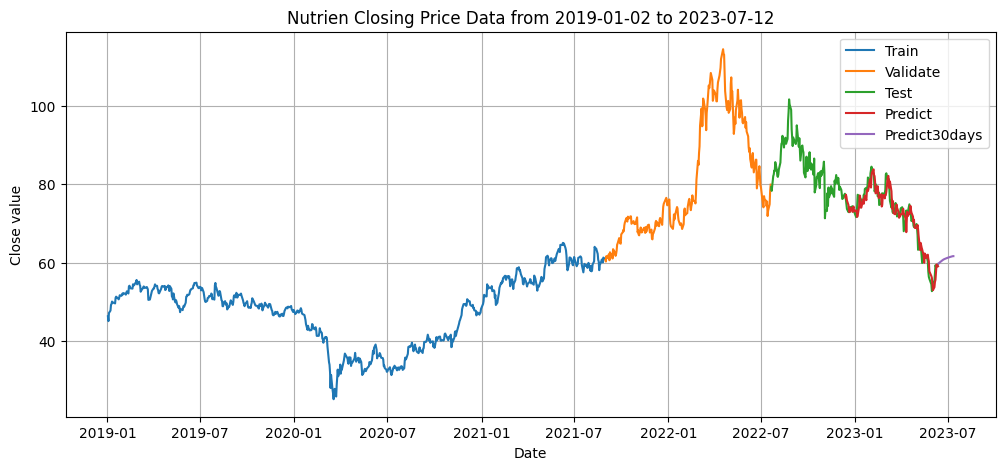

In [21]:
plt.figure(figsize=(12, 5))

plt.plot(df.index[:train_size], scaler.inverse_transform(train_data))

plt.plot(df.index[train_size : train_size + val_size], scaler.inverse_transform(val_data))

plt.plot(df.index[train_size + val_size : ], scaler.inverse_transform(test_data))

plt.plot(df.index[train_size + val_size + best_window_size + 1: ], best_y_pred)

plt.plot(index_next_30_days, scaler.inverse_transform(np.array(y_next_30_days).reshape(-1, 1)))

plt.legend(['Train', 'Validate', 'Test', 'Predict', 'Predict30days'])

plt.grid()
plt.title(f"Nutrien Closing Price Data from {df.index[0].strftime('%Y-%m-%d')} to {index_next_30_days[-1].strftime('%Y-%m-%d')}")
plt.xlabel("Date")
plt.ylabel("Close value")
plt.savefig('TCAN_622_NTR.png')
plt.show()